## Artificial Intelligence (AI) Assisted Skin Wound Classification and Screening System (Binary Classification) - Final Modularized Code File

In [2]:
import os
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import tensorflow as tf
from sklearn.metrics import confusion_matrix, classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array


class DataLoader:
    def __init__(self, train_path, val_path, test_path, image_size=(64, 64), batch_size=32):
        self.train_path = train_path
        self.val_path = val_path
        self.test_path = test_path
        self.image_size = image_size
        self.batch_size = batch_size

    def load_data(self):
        # Data Augmentation for Training Set
        train_datagen = ImageDataGenerator(
            rescale=1./255,
            shear_range=0.2,
            zoom_range=0.2,
            horizontal_flip=True
        )

        val_test_datagen = ImageDataGenerator(rescale=1./255)

        training_set = train_datagen.flow_from_directory(
            self.train_path,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )

        validation_set = val_test_datagen.flow_from_directory(
            self.val_path,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )

        test_set = val_test_datagen.flow_from_directory(
            self.test_path,
            target_size=self.image_size,
            batch_size=self.batch_size,
            class_mode='binary'
        )

        return training_set, validation_set, test_set



In [3]:
class CNNModel:
    def __init__(self, input_shape=(64, 64, 3), learning_rate=0.001):
        self.input_shape = input_shape
        self.learning_rate = learning_rate

    def build_model(self):
        model = Sequential()

        # Convolutional Layers
        model.add(Conv2D(32, kernel_size=3, activation='relu', input_shape=self.input_shape))
        model.add(MaxPooling2D(pool_size=2, strides=2))

        model.add(Conv2D(64, kernel_size=3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2, strides=2))

        model.add(Conv2D(128, kernel_size=3, activation='relu'))
        model.add(MaxPooling2D(pool_size=2, strides=2))

        # Fully Connected Layers
        model.add(Flatten())
        model.add(Dense(128, activation='relu'))
        model.add(Dropout(0.25))
        model.add(Dense(1, activation='sigmoid'))  # Binary classification

        # Compile Model
        model.compile(optimizer=Adam(learning_rate=self.learning_rate),
                      loss='binary_crossentropy',
                      metrics=['accuracy'])
        return model

In [4]:
class Trainer:
    def __init__(self, model, training_set, validation_set, epochs=100):
        self.model = model
        self.training_set = training_set
        self.validation_set = validation_set
        self.epochs = epochs

    def train(self):
        history = self.model.fit(
            x=self.training_set,
            steps_per_epoch=self.training_set.samples // self.training_set.batch_size,
            validation_data=self.validation_set,
            validation_steps=self.validation_set.samples // self.validation_set.batch_size,
            epochs=self.epochs
        )
        return history

    def plot_history(self, history):
        plt.figure(figsize=(12, 5))

        # Accuracy
        plt.subplot(1, 2, 1)
        plt.plot(history.history['accuracy'], label='Train Accuracy')
        plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
        plt.title('Accuracy Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Accuracy')
        plt.legend()

        # Loss
        plt.subplot(1, 2, 2)
        plt.plot(history.history['loss'], label='Train Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Loss Over Epochs')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.tight_layout()
        plt.show()



In [5]:
class Evaluator:
    def __init__(self, model, class_indices):
        self.model = model
        self.class_indices = class_indices
        self.reverse_class_indices = {v: k for k, v in class_indices.items()}

    def evaluate_predictions(self, test_image_dir, label_dirs):
        true_labels = []
        predicted_labels = []

        # Gather true labels from folder structure
        for label_name, label_dir in label_dirs.items():
            for img_name in os.listdir(label_dir):
                if img_name.lower().endswith(('jpg', 'jpeg')):
                    true_labels.append(self.class_indices[label_name])

        # Predict using model
        for img_name in os.listdir(test_image_dir):
            if img_name.lower().endswith(('jpg', 'jpeg')):
                img_path = os.path.join(test_image_dir, img_name)
                img = load_img(img_path, target_size=(64, 64))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=0) / 255.0
                result = self.model.predict(img_array)
                predicted_class = int(result[0][0] >= 0.5)
                predicted_labels.append(predicted_class)

        # Convert to NumPy arrays
        true_labels = np.array(true_labels)
        predicted_labels = np.array(predicted_labels)

   # Evaluation metrics
        conf_matrix = confusion_matrix(true_labels, predicted_labels)
        class_report = classification_report(true_labels, predicted_labels)

        # Output
        print("Confusion Matrix:\n", conf_matrix)
        print("Classification Report:\n", class_report)

        # Plot confusion matrix
        plt.figure(figsize=(6, 5))
        sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues')
        plt.title('Confusion Matrix')
        plt.xlabel('Predicted Label')
        plt.ylabel('True Label')
        plt.show()

Found 900 images belonging to 2 classes.
Found 350 images belonging to 2 classes.
Found 240 images belonging to 2 classes.


C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)
C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 33s 1s/step - accuracy: 0.5320 - loss: 0.6984 - val_accuracy: 0.6844 - val_loss: 0.6383
Epoch 2/100
 1/28 ━━━━━━━━━━━━━━━━━━━━ 7s 268ms/step - accuracy: 0.5625 - loss: 0.6641

C:\Users\LENOVO\anaconda3\Lib\site-packages\keras\src\trainers\epoch_iterator.py:107: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 227ms/step - accuracy: 0.5625 - loss: 0.6641 - val_accuracy: 0.6531 - val_loss: 0.6345
Epoch 3/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6023 - loss: 0.6461 - val_accuracy: 0.6906 - val_loss: 0.5783
Epoch 4/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 201ms/step - accuracy: 0.6250 - loss: 0.6006 - val_accuracy: 0.7094 - val_loss: 0.5718
Epoch 5/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 28s 1s/step - accuracy: 0.6565 - loss: 0.5817 - val_accuracy: 0.6750 - val_loss: 0.6261
Epoch 6/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 211ms/step - accuracy: 0.5625 - loss: 0.6671 - val_accuracy: 0.7094 - val_loss: 0.5354
Epoch 7/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 29s 1s/step - accuracy: 0.6345 - loss: 0.5882 - val_accuracy: 0.7188 - val_loss: 0.5735
Epoch 8/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 6s 197ms/step - accuracy: 0.5625 - loss: 0.6333 - val_accuracy: 0.7156 - val_loss: 0.5731
Epoch 9/100
28/28 ━━━━━━━━━━━━━━━━━━━━ 25s 890ms/step - accuracy: 0.6765 - loss: 0.5933 - val_accuracy: 0.7094 - va

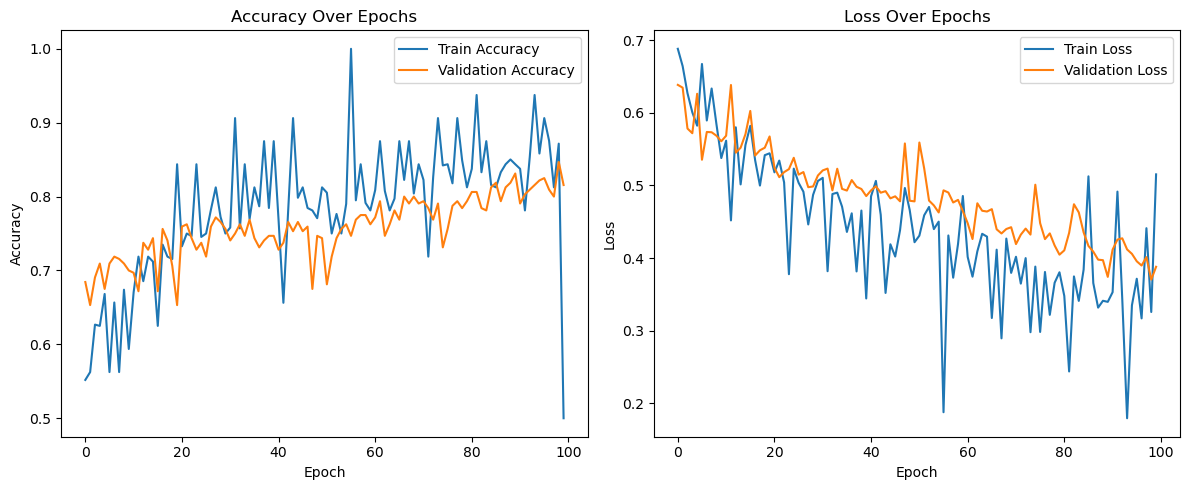

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 138ms/step
1/1 ━━━━━━

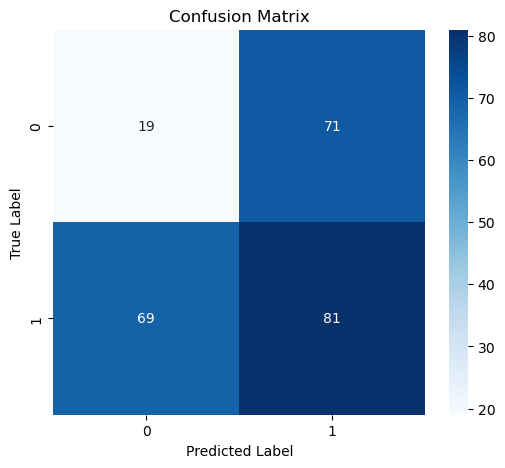

In [6]:
def main():
    # File Paths
    training_data = 'D:/University_California_SanDiego/Coursework Files/Introduction to Artificial Intelligence AAI 501/Final Project/dataset_2/training_set'
    validation_data = 'D:/University_California_SanDiego/Coursework Files/Introduction to Artificial Intelligence AAI 501/Final Project/dataset_2/validation_set'
    test_data = 'D:/University_California_SanDiego/Coursework Files/Introduction to Artificial Intelligence AAI 501/Final Project/dataset_2/test_set'
    prediction_data = 'D:/University_California_SanDiego/Coursework Files/Introduction to Artificial Intelligence AAI 501/Final Project/dataset_2/Prediction_set'

    label_dirs = {
        'Actinic keratosis': os.path.join(test_data, 'Actinic keratosis'),
        'Benign keratosis': os.path.join(test_data, 'Benign keratosis')
    }

    # Load Data
    loader = DataLoader(training_data, validation_data, test_data)
    train_set, val_set, test_set = loader.load_data()

    # Build Model
    cnn_builder = CNNModel()
    model = cnn_builder.build_model()

    # Train Model
    trainer = Trainer(model, train_set, val_set)
    history = trainer.train()
    trainer.plot_history(history)

    # Evaluate Model 
    evaluator = Evaluator(model, train_set.class_indices)
    evaluator.evaluate_predictions(prediction_data, label_dirs)


if __name__ == "__main__":
    main()
    